In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px

In [3]:
def load_data_from_sqlite(db_path):
   
    conn = sqlite3.connect(db_path) 
    
    query = """
    SELECT name, property_type, street, ward, district, 
           price_total, price_m2, area, long as longitude, lat as latitude
    FROM real_estate_processed
    WHERE price_total > 0 AND area > 0 AND long IS NOT NULL AND lat IS NOT NULL
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    return df

DB_PATH = '../data_real_estate.db'
df = load_data_from_sqlite(DB_PATH)

In [4]:
print(f"Số bản ghi ban đầu: {len(df)}")

# Lọc các giá trị không hợp lý
df = df[(df['price_total'] > 100e6) & (df['price_total'] < 500e9)]  # Giá từ 100 triệu đến 500 tỷ
df = df[(df['area'] >= 10)]  # Diện tích từ 10 m2

print(f"Số bản ghi sau khi lọc: {len(df)}")

Số bản ghi ban đầu: 20
Số bản ghi sau khi lọc: 19


In [13]:
# Kiểm tra và xử lý giá trị thiếu (nếu có)
df = df.dropna()

# Chọn các cột số để clustering
data = df[['price_total', 'price_m2', 'area', 'longitude', 'latitude']].values

In [14]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

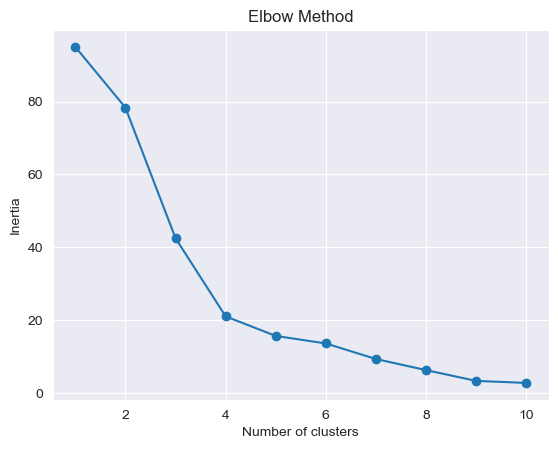

In [15]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [16]:
# Khởi tạo và huấn luyện mô hình K-means
kmeans = KMeans(n_clusters=3, random_state=42)  # Giả sử chọn k=3 cụm
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=42)

In [17]:
# Lấy nhãn cụm và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [18]:
# Thêm nhãn cụm vào DataFrame
df['cluster'] = labels

In [30]:
# In số lượng bất động sản trong mỗi cụm
print("Số lượng bất động sản trong mỗi cụm:")
print(df['cluster'].value_counts())
print(pd.DataFrame(df, columns=['name', 'price_total', 'cluster']))

Số lượng bất động sản trong mỗi cụm:
cluster
1    16
0     2
2     1
Name: count, dtype: int64
                                                 name   price_total  cluster
0   Bán lô đất kiệt 74 Ngô Thì Nhậm ngang 6,2m, DT...  3.650000e+09        1
1   Cần bán lô đất MT lên nhà số 38 đường Bàu Năng...  4.250000e+09        1
2   Mặt tiền đường Vũ Văn Cẩn trục thông kinh doan...  3.970000e+09        1
3   Bán gần 400m2 đất biển Đà Nẵng chỉ cách bờ biể...  1.270000e+08        2
4   Siêu vip, siêu hiếm Phạm Đình Hổ ngang 7m thôn...  7.300000e+09        1
5   Lô góc hàng hiếm vị trí kinh doanh đặc biệt đư...  1.280000e+10        1
6   Mặt tiền Nguyễn Phước Lan tuyến đường huyết mạ...  1.150000e+10        1
7   Chủ cần bán lô đất thượng mại dịch vụ đảo xanh...  4.320000e+10        0
8   Bán đất giá 37tr/m2, Quận Ngũ Hành Sơn, đường ...  1.350000e+10        1
9   Đất nền bán tại Lê Thạch, Hòa An, Cẩm Lệ, Đà N...  4.200000e+09        1
10  Đất 7.5m đối diện block biệt thự gần cầu Khuê ...  3.3

In [21]:
# In thông tin tâm cụm (đã chuẩn hóa)
print("\nTâm cụm (centroids) trong không gian chuẩn hóa:")
print(pd.DataFrame(centroids, columns=['price_total', 'price_m2', 'area', 'longitude', 'latitude']))


Tâm cụm (centroids) trong không gian chuẩn hóa:
   price_total  price_m2      area  longitude  latitude
0     2.490605 -0.229823  0.326467   1.033619 -0.165221
1    -0.255765 -0.236436 -0.259159  -0.221828 -0.027640
2    -0.888974  4.242617  3.493602   1.482014  0.772687


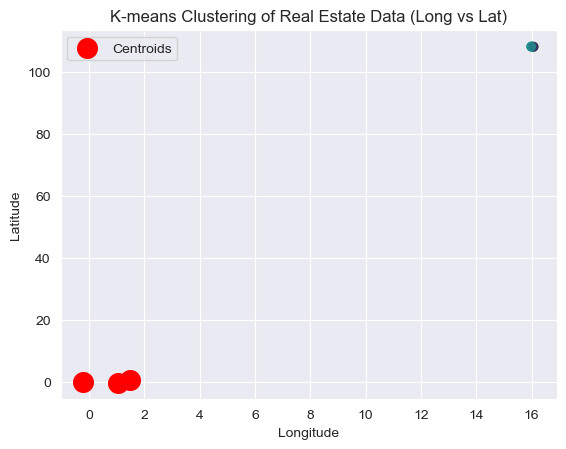

In [22]:
# Vẽ biểu đồ phân cụm dựa trên kinh độ (long) và vĩ độ (lat)
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 3], centroids[:, 4], c='red', marker='o', s=200, label='Centroids')
plt.title('K-means Clustering of Real Estate Data (Long vs Lat)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()